# Image colorization for Images of size 32*32

In [1]:
import torch
import torch.nn.functional as F
import torch.nn as nn
import torch.optim as optim
import torchvision
from torchvision import transforms
from torchvision.transforms import Grayscale
import numpy as np
from PIL import Image
import cv2 as cv



torch.cuda.is_available()
# Device configuration
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [2]:
#Hyperparameters
EPOCHS = 20
BATCH_SIZE = 90
LEARNING_RATE = 0.002


In [3]:
import torch.utils


transform = transforms.Compose([transforms.ToTensor()
                                #transforms.Normalize([0.5, 0.5, 0.5], [0.5, 0.5, 0.5])
                                ])

train_dataset = torchvision.datasets.CIFAR10(root = "./CIFAR_data", train=True, download=True, transform=transform)

test_dataset = torchvision.datasets.CIFAR10(root = "./CIFAR_data", train=False, download=True, transform=transform)

train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)

test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=True)

Files already downloaded and verified
Files already downloaded and verified


In [4]:
class ConvNet(nn.Module):
    def __init__(self):
        super(ConvNet, self).__init__()
        self.pool = nn.MaxPool2d(2,2)
        self.conv1 = nn.Conv2d(1, 32, 3)
        self.conv2 = nn.ConvTranspose2d(32, 64, 3, stride = 2)
        self.conv3 = nn.ConvTranspose2d(64, 128, 4, stride = 4)
        self.conv4 = nn.ConvTranspose2d(128, 64, 3)
        #self.conv6 = nn.ConvTranspose2d(256, 256, 3, stride = 2)
        self.conv5 = nn.Conv2d(64, 3, 1)
    def forward(self, x):
        #print(x.shape)
        x = F.relu(self.conv1(x))   
        #print(x.shape)
        x = self.pool(x)    
        #print(f"nach pooling {x.shape}")  
        x = F.relu(self.conv2(x))   
        #print(x.shape)  
        #x = self.pool(x)            
        #print(f"nach pooling {x.shape}")
        x = F.relu(self.conv3(x))   
        #print(x.shape)  
        x = self.pool(x)            
        #print(f"nach pooling {x.shape}")
        x = F.relu(self.conv4(x))   
        #x = F.relu(self.conv6(x)) 
        #print(x.shape)  
        x = self.pool(x)         
        #print(x.shape)  
        #x = F.relu(self.conv5(x))  
        x = torch.sigmoid(self.conv5(x))
        #print(f"nach sigmoid {x.shape}")
        return x
        
model = ConvNet().to(device) #verschieben auf die GPU

In [5]:
criterion = nn.MSELoss().to(device)
optimizer = optim.Adam(model.parameters(), lr = LEARNING_RATE)

In [6]:
def rgb_to_gray(img):
    return img.mean(dim=1, keepdim=True)

def denormalize(tensor):
    # Annahme: tensor hat Form (C, H, W) und ist im Bereich [-1, 1] nach Normalisierung
    denorm = tensor.clone()  # Erstellen einer Kopie des Tensors, um das Original zu bewahren
    for t in range(denorm.size(0)):  # Für jeden Farbkanal
        denorm[t] = denorm[t] * 0.5 + 0.5  # Rücknormalisierung mit Standardabweichung und Mittelwert
    return denorm

In [7]:
def train_one_epoch(epoch_index, tb_writer):
    running_loss = 0.
    last_loss = 0.

    # Here, we use enumerate(training_loader) instead of
    # iter(training_loader) so that we can track the batch
    # index and do some intra-epoch reporting
    for i, (images,_) in enumerate(train_loader):
        #grayscaling images for training
        grayscale_images = rgb_to_gray(images)
        images = images.to(device)
        # defining model inputs
        inputs= grayscale_images.to(device)


        # Zero your gradients for every batch!
        optimizer.zero_grad()

        # Make predictions for this batch
        outputs = model(inputs)
        
        # Compute the loss and its gradients
        loss = criterion(outputs, images)
        loss.backward()

        # Adjust learning weights
        optimizer.step()

        # Gather data and report
        running_loss += loss.item()
        if i % 1000 == 999:
            last_loss = running_loss / 1000 # loss per batch
            print('  batch {} loss: {}'.format(i + 1, last_loss))
            tb_x = epoch_index * len(train_loader) + i + 1
            tb_writer.add_scalar('Loss/train', last_loss, tb_x)
            running_loss = 0.

    return last_loss



In [8]:
"""code from pytorch turorial
https://pytorch.org/tutorials/beginner/introyt/trainingyt.html"""
import os

from datetime import datetime
from torch.utils.tensorboard import SummaryWriter

# Initializing in a separate cell so we can easily add more epochs to the same run
timestamp = datetime.now().strftime('%Y%m%d_%H%M%S')
writer = SummaryWriter('runs/CIFAR_colorization_HSV_{}'.format(timestamp))
epoch_number = 0

best_vloss = 1_000_000.

model = model.to(device)
for epoch in range(EPOCHS):
    print('EPOCH {}:'.format(epoch_number + 1))

    # Make sure gradient tracking is on, and do a pass over the data
    model.train(True)
    avg_loss = train_one_epoch(epoch_number, writer)


    running_vloss = 0.0
    # Set the model to evaluation mode, disabling dropout and using population
    # statistics for batch normalization.
    model.eval()

    # Disable gradient computation and reduce memory consumption.
    with torch.no_grad():
        for i,  (vimages,_) in enumerate(test_loader):
            vimages = vimages.to(device)
            vimages_grayscale = rgb_to_gray(vimages)
            vinputs = vimages_grayscale.to(device)
            voutputs = model(vinputs).to(device)
            vloss = criterion(voutputs, vimages)
            running_vloss += vloss

    avg_vloss = running_vloss / (i + 1)
    print('LOSS train {} valid {}'.format(avg_loss, avg_vloss))

    # Log the running loss averaged per batch
    # for both training and validation
    writer.add_scalars('Training vs. Validation Loss',
                    { 'Training' : avg_loss, 'Validation' : avg_vloss },
                    epoch_number + 1)
    writer.flush()

    # Track best performance, and save the model's state
    if avg_vloss < best_vloss:
        best_vloss = avg_vloss

        #os.mkdir('./runs/CIFAR_colorization_{}./models'.format(timestamp))
        #model_path = './runs/CIFAR_colorization_{}./models/model_{}_{}'.format(timestamp, timestamp, epoch_number)
        model_path = './models/model_HSV_{}_{}'.format( timestamp, epoch_number)
        torch.save(model.state_dict(), model_path)
        #print(f"saved checkpoint in {model_path}")

    epoch_number += 1

EPOCH 1:


KeyboardInterrupt: 

0.45572677


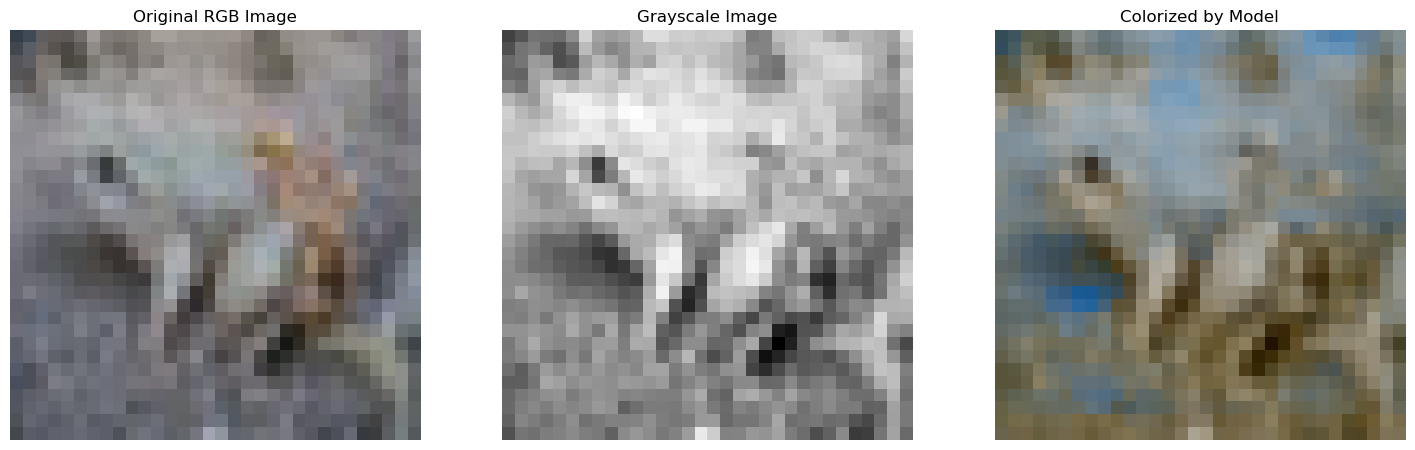

0.45572677


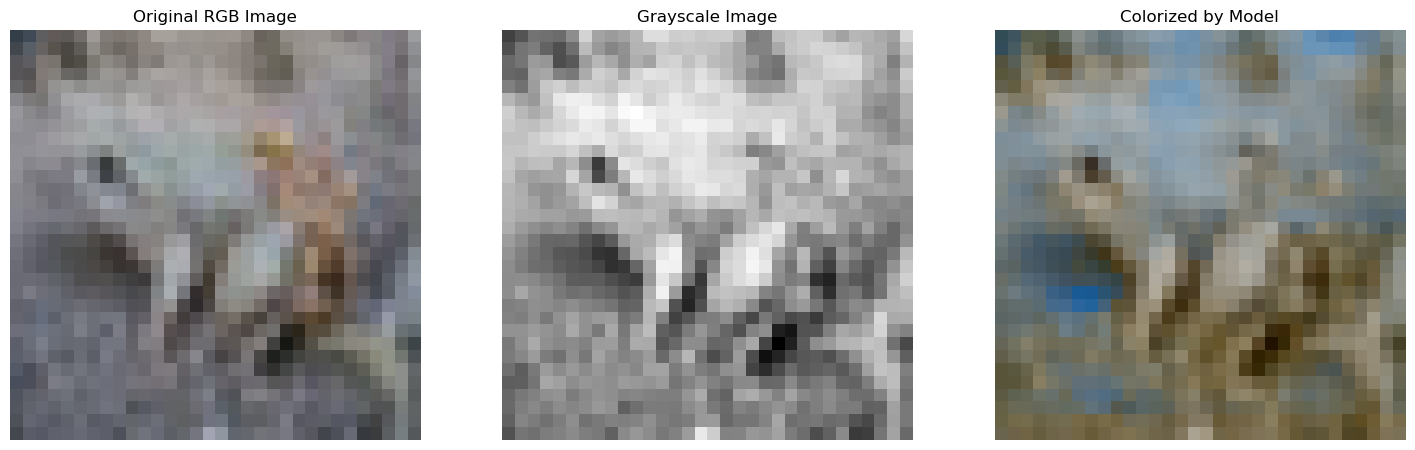

In [21]:
import torch
import matplotlib.pyplot as plt
import numpy as np


# Funktion zum Umwandeln eines Torch-Tensors in ein Numpy-Array
def im_convert(tensor):
    image = tensor.cpu().clone().detach().numpy()
    image = np.transpose(image, (1, 2, 0))  # Von (C, H, W) zu (H, W, C)
    #image = np.clip(image, 0, 1)  # Werte zwischen 0 und 1 setzen
    return image

# Visualisierungsfunktion
def plot_images(original, grayscale, colorized):
    original_img = im_convert(original[0])  # Originalbild (RGB)
    grayscale_img = im_convert(grayscale[0])  # Graustufenbild
    colorized_img = im_convert(colorized[0])  # Vom Modell eingefärbtes Bild
    print(colorized_img.mean())
    fig, ax = plt.subplots(1, 3, figsize=(18, 6))
    
    # Originalbild
    ax[0].imshow(original_img)
    ax[0].set_title("Original RGB Image")
    ax[0].axis('off')
    
    # Grauwertbild
    ax[1].imshow(grayscale_img, cmap='gray')
    ax[1].set_title("Grayscale Image")
    ax[1].axis('off')
    
    # Vom Modell eingefärbtes Bild
    ax[2].imshow(colorized_img)
    ax[2].set_title("Colorized by Model")
    ax[2].axis('off')
    
    plt.show()

def denormalize(tensor):
    # Annahme: tensor hat Form (C, H, W) und ist im Bereich [-1, 1] nach Normalisierung
    denorm = tensor.clone()  # Erstellen einer Kopie des Tensors, um das Original zu bewahren
    for t in range(denorm.size(0)):  # Für jeden Farbkanal
        denorm[t] = denorm[t] * 0.5 + 0.5  # Rücknormalisierung mit Standardabweichung und Mittelwert
    return denorm

# Beispiel: Zeige ein Bild, graues Bild und das durch das Modell eingefärbte Bild an
try:
    model.eval()  # Schalte das Modell in den Evaluierungsmodus
except (NameError,AttributeError) as e:
    #loading model if not loaded already
    #need to adjust the path manually
    trained_model_path = ".\models\model_20241104_232646_18"
    model = ConvNet()
    model.load_state_dict(torch.load(trained_model_path, weights_only="True"))
    model.eval().to(device)

#if images != None:
with torch.no_grad():  # Keine Gradient-Berechnung nötig
    for i, (images, _) in enumerate(test_loader):
        #images = denormalize(images)
        grayscale_images = rgb_to_gray(images).to(device)
        images = images.to(device)
        # Vorhersage durch das Modell
        outputs = model(grayscale_images)

        
        #outputs = denormalize(outputs)
        # Plotte das Original, das Grauwertbild und das eingefärbte Bild
        plot_images(images, grayscale_images, outputs)

        break  # Nur für ein Beispiel, damit die Schleife nicht endlos läuft"""

grayscale_images = rgb_to_gray(images).to(device)
images = images.to(device)

# Vorhersage durch das Modell
outputs = model(grayscale_images)

#images = denormalize(images)
#outputs = denormalize(outputs)
# Plotte das Original, das Grauwertbild und das eingefärbte Bild
plot_images(images, grayscale_images, outputs)


In [12]:
model = None

In [ ]:
for i, (images, _) in enumerate(train)

tensor([[[0.6627, 0.6588, 0.6627,  ..., 0.6510, 0.4392, 0.3647],
         [0.6706, 0.6667, 0.6706,  ..., 0.3725, 0.3412, 0.5059],
         [0.6784, 0.6784, 0.6824,  ..., 0.4000, 0.5137, 0.4980],
         ...,
         [0.9020, 0.8392, 0.7882,  ..., 0.7020, 0.6980, 0.7137],
         [0.7059, 0.6980, 0.6039,  ..., 0.7176, 0.6588, 0.7098],
         [0.4353, 0.4275, 0.3216,  ..., 0.7059, 0.6588, 0.7059]],

        [[0.7843, 0.7804, 0.7843,  ..., 0.7333, 0.4980, 0.3961],
         [0.7922, 0.7882, 0.7882,  ..., 0.4392, 0.3843, 0.5176],
         [0.8000, 0.8000, 0.8039,  ..., 0.4314, 0.5098, 0.4745],
         ...,
         [0.8314, 0.7647, 0.7176,  ..., 0.6667, 0.6627, 0.6745],
         [0.6667, 0.6549, 0.5647,  ..., 0.6824, 0.6235, 0.6706],
         [0.4392, 0.4235, 0.3255,  ..., 0.6706, 0.6235, 0.6667]],

        [[0.9725, 0.9647, 0.9686,  ..., 0.8118, 0.5294, 0.4078],
         [0.9765, 0.9686, 0.9725,  ..., 0.4510, 0.3686, 0.5216],
         [0.9765, 0.9686, 0.9765,  ..., 0.4510, 0.5176, 0.

In [ ]:
image = torchvision.transforms.functional.to_pil_image(original, mode=None)
image.show()
